# Cuda Simulator

In [1]:
"""Setup"""
import numpy as np
import sys
#from google.colab import drive
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.mplot3d import Axes3D
from viz_cuda import *
from optics_cuda import *

#drive.mount("/content/gdrive")
#np.set_printoptions(
#    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
#)
# the code in this notebook is formatted with Black https://black.vercel.app/ using 3.7, which is what this says:
print(sys.version)

CuPy version 11.0.0
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
%%time
""" Generate some photons from the LED.

For now use Lambertian, it's pretty close.
TODO: use the Cree distribution
Say the units are like 100 microns?  so like 1mm square?
TODO: calibrate the size
TODO: calibrate the output
"""

###
photon_count = np.int32(25000000)
source_size = np.float32(10)
###
photons = LambertianSource(source_size, source_size).make_photons(photon_count)
print(f"LED emitted photons: {photons.size()}")

LED emitted photons: 25000000
CPU times: user 245 ms, sys: 29 ms, total: 274 ms
Wall time: 295 ms


CPU times: user 98.9 ms, sys: 0 ns, total: 98.9 ms
Wall time: 98.1 ms


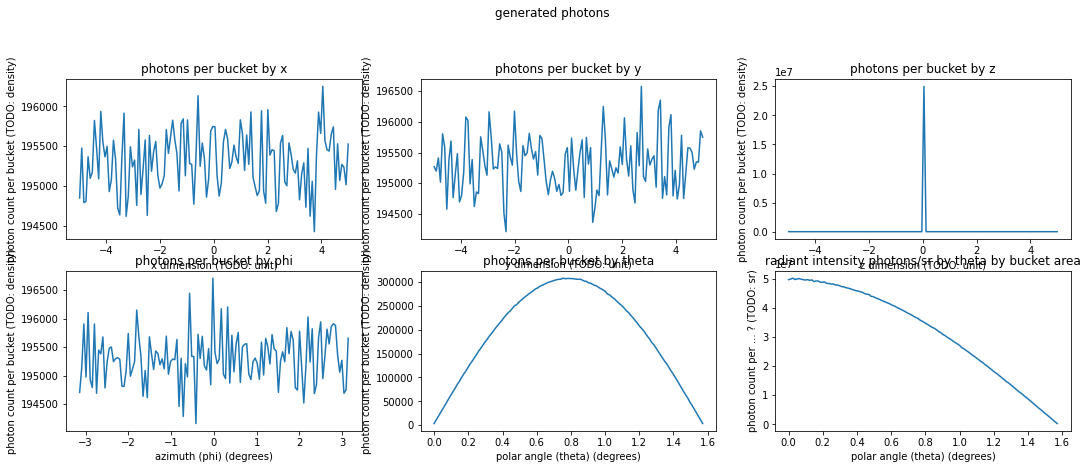

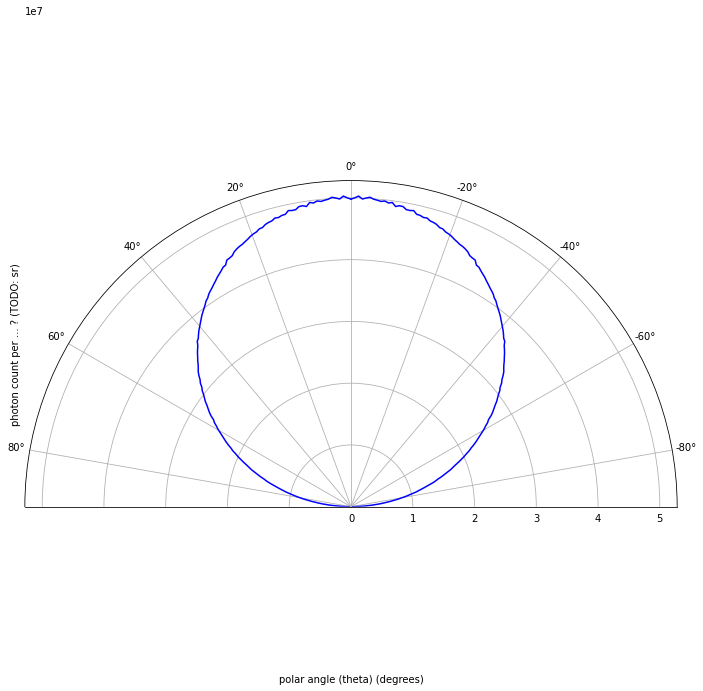

In [3]:
%%time
""" Look at the distributions of the generated photons."""
plot_histogram_slices(photons, "generated photons",
                      x_min = -source_size/2, x_max = source_size/2,
                      y_min = -source_size/2, y_max = source_size/2,
                      z_min = -5, z_max = 5,
                      theta_max = np.pi/2)

In [4]:
%%time
"""Look at the photons in 3d."""
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
source_sample = photons.sample()
plot_3d([source_sample], ray_lengths=[1], boxes=[source_box], labels=['LED'], colors=[0xffff00])

Output()

CPU times: user 27.3 ms, sys: 3.86 ms, total: 31.1 ms
Wall time: 27.1 ms


In [5]:
%%time
""" Propagate the photons to the diffuser.

Most arrive at the diffuser surface.
Some are absorbed by the imperfectly reflective lightbox.
A square profile (or undersquare) helps keep the intensity even at the top. 
"""
###
lightbox_height = 400
lightbox_size = 400
###

lightbox = Lightbox(height = lightbox_height, size = lightbox_size)
lightbox.propagate(photons)
print(f"diffuser incident photons: {photons.size()}")

diffuser incident photons: 21120661
CPU times: user 3.89 s, sys: 1.94 ms, total: 3.89 s
Wall time: 3.89 s


In [6]:
%%time
box_sample = photons.sample()
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
plot_3d([source_sample, box_sample], ray_lengths=[100, 100],
        boxes=[source_box, lightbox_box], labels=['LED','lightbox'], colors=[0xffff00, 0x00ffff])

Output()

CPU times: user 33.8 ms, sys: 4.11 ms, total: 37.9 ms
Wall time: 32 ms


CPU times: user 98.3 ms, sys: 121 µs, total: 98.5 ms
Wall time: 96.6 ms


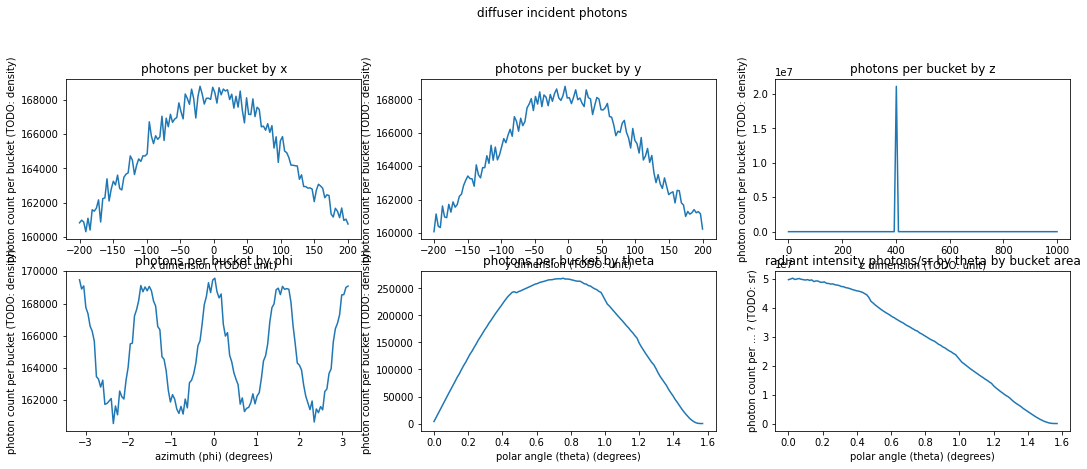

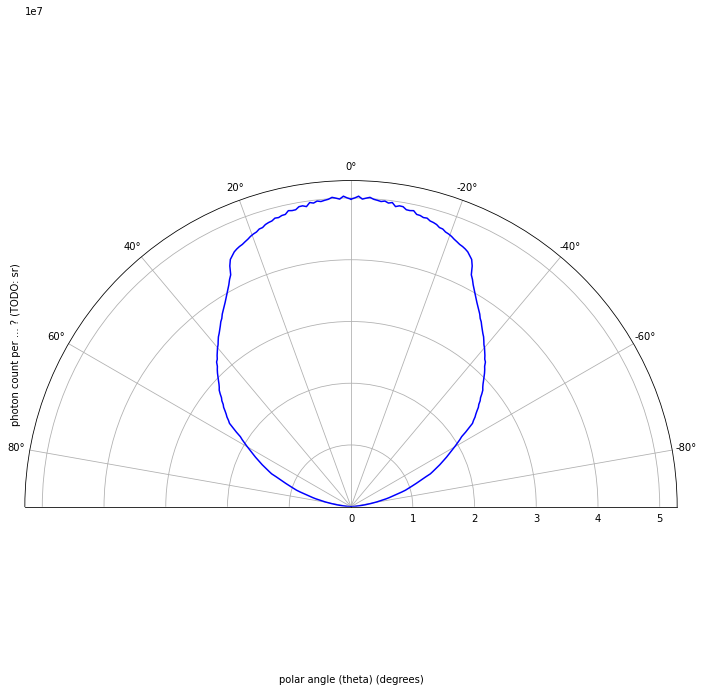

In [7]:
%%time
""" Show distributions of diffuser incident photons."""
plot_histogram_slices(photons, "diffuser incident photons",
                      x_min=-200, x_max=200,
                      y_min=-200, y_max=200,
                      z_min=0, z_max=1000, 
                      theta_max = np.pi/2)

In [8]:
%%time
""" Diffuse through the diffuser. """
photons.decimate(0.16)
diffuser = Diffuser(g = np.float32(0.64), absorption = np.float32(0.16))
diffuser.diffuse(photons)
print(f"diffuser-transmitted photons: {photons.size()}")

diffuser-transmitted photons: 14901751
CPU times: user 132 ms, sys: 3.73 ms, total: 135 ms
Wall time: 135 ms


CPU times: user 142 ms, sys: 285 µs, total: 142 ms
Wall time: 138 ms


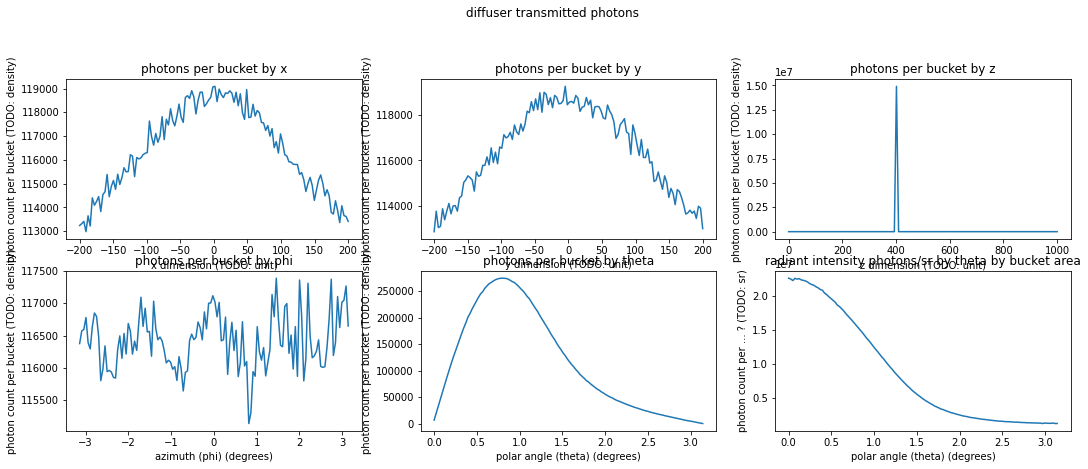

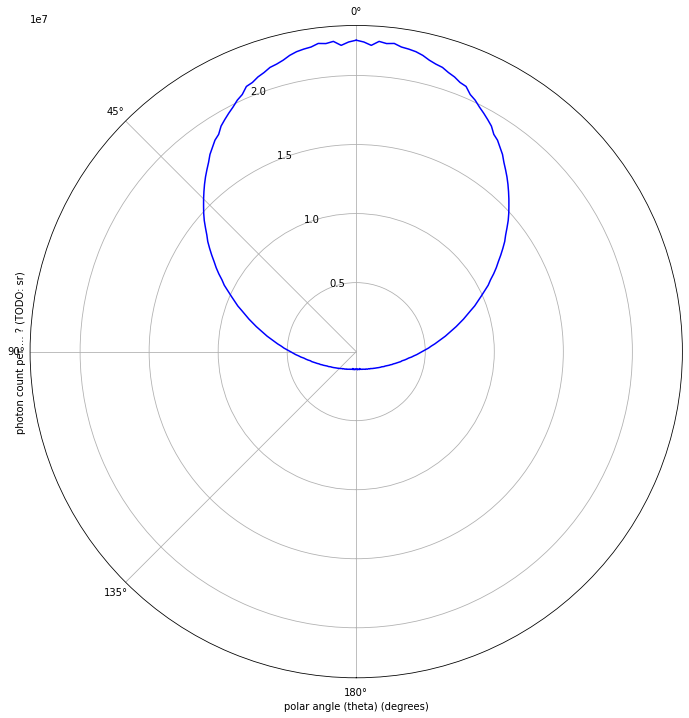

In [9]:
%%time
""" Show the distributions of photons transmitted by the diffuser.

Notice the distribution goes all the way to 180 degrees, a small fraction
of the incident photons are scattered downward.
"""
plot_histogram_slices(photons, "diffuser transmitted photons",
                      x_min=-200, x_max=200,
                      y_min=-200, y_max=200,
                      z_min=0, z_max=1000, 
                      theta_max = np.pi)

In [10]:
%%time
""" Show the LED-produced and diffuser-transmitted photons in 3d. """
diff_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height+1]
diff_sample = photons.sample()
plot_3d([source_sample, box_sample, diff_sample],
        ray_lengths=[10, 10, 100],
        boxes=[source_box, lightbox_box, diff_box],
        labels=['LED', 'lightbox', 'diffuser'],
        colors=[0xffff00, 0x00ffff, 0xff00ff])

Output()

CPU times: user 94.7 ms, sys: 20.8 ms, total: 116 ms
Wall time: 41.8 ms


# ==== START HERE ====

In [11]:
print(photons.ez_x)
print(photons.ez_y)
print(photons.ez_z)
print(photons.alive)

[ 0.71961945 -0.79717165 -0.86115617 ...  0.9576671  -0.9596007
  0.73925406]
[-0.32175753 -0.5651406   0.4379829  ... -0.23275484  0.2812441
 -0.54765254]
[ 0.6153211   0.2124466   0.25803337 ...  0.16940813 -0.00826816
  0.39189348]
[ True  True  True ...  True  True  True]


In [12]:
%%time
""" Propagate diffuser-transmitted photons to the (far away) reflector. """
# TODO: units.
# for now, unit is 100 microns, so
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
# reflector size might be 10cm square (=1000)

###
reflector_distance = np.float32(100000)
###

#propagateToReflector(photons, location = reflector_distance, size = 1000)
propagate_to_reflector(photons, location = reflector_distance, size = np.float32(1000))

print(f"reflector-incident photons: {photons.size()}")

[0.6153211  0.2124466  0.25803337 ... 0.50754833 0.16940813 0.39189348]
[0.6153211  0.2124466  0.25803337 ... 0.50754833 0.16940813 0.39189348]
[0.6153211  0.2124466  0.25803337 ... 0.50754833 0.16940813 0.39189348]
[0.9999981  0.9999812  0.99998504 0.999988   0.99999756 0.9999858
 0.9999913  0.99999774 0.99997073 0.99999565 0.9999863  0.9999746
 0.99997735 0.9999873  0.9999925  0.9999953  0.9999978  0.9999994
 0.9999819  0.99999976 0.99998933 0.99998355 0.9999953  0.99999946
 0.99997467 0.9999719  0.99997944 0.9999899  0.99998885 0.9999947
 0.99999166 0.9999955  0.99999577 0.99999946 0.99999744 0.99998844
 0.999995   0.999981   0.99999315 0.9999911  0.9999954  0.99998903
 0.99998826 0.9999997  0.9999933  0.9999896  0.99999344 0.9999865
 0.9999934  0.9999848  0.9999966  0.9999954  0.9999945  0.99997514
 0.9999873  0.9999764  0.9999874  0.9999885  0.9999966  0.9999919
 0.99999106 0.99999386 0.99998057 0.9999779  0.9999978  0.9999909
 0.9999877  0.9999926  0.9999893  0.9999932  0.9999848

In [13]:
print(reflector_distance)
print(photons.ez_x)
print(photons.ez_y)
print(photons.ez_z)
print(photons.alive)

100000.0
[ 1.3814493e-03 -5.4964605e-03 -5.5106153e-04  7.5876620e-04
  8.1786705e-04  5.0793216e-03  3.9940155e-03 -1.8178850e-03
 -6.2077045e-03 -2.4865065e-03 -4.6756649e-03  6.6103525e-03
  6.5930854e-03 -4.7127390e-03  2.0893293e-03 -5.4379710e-04
  1.5333039e-03  8.2822453e-04 -3.3416981e-03  4.9153500e-04
 -2.3805448e-03 -4.6849977e-03 -3.0751745e-03  1.0039227e-03
  4.5740390e-03 -6.1003324e-03  3.7253425e-03  4.4533522e-03
 -4.6808445e-03 -2.6647914e-03 -2.0318071e-03 -2.9775500e-03
 -2.3935477e-03 -8.7664701e-04 -1.9658715e-03  4.7949590e-03
  1.4429552e-03  4.2228680e-03  2.1153216e-03 -9.0459839e-04
  2.3600457e-03  4.2609135e-03 -3.8926541e-03 -7.9651910e-04
 -3.2677401e-03  1.3139913e-03  2.1115153e-03 -4.9559381e-03
 -6.9623877e-04 -2.5786094e-03 -1.3379547e-03  3.1329575e-04
  7.5063261e-04  6.0152551e-03 -2.8792170e-03  4.0278235e-03
  4.3124338e-03  1.9333437e-03 -1.9930664e-03  4.0237196e-03
  2.8756408e-03 -2.4448065e-03  4.1027190e-03  6.0264478e-03
 -1.1235825e-03

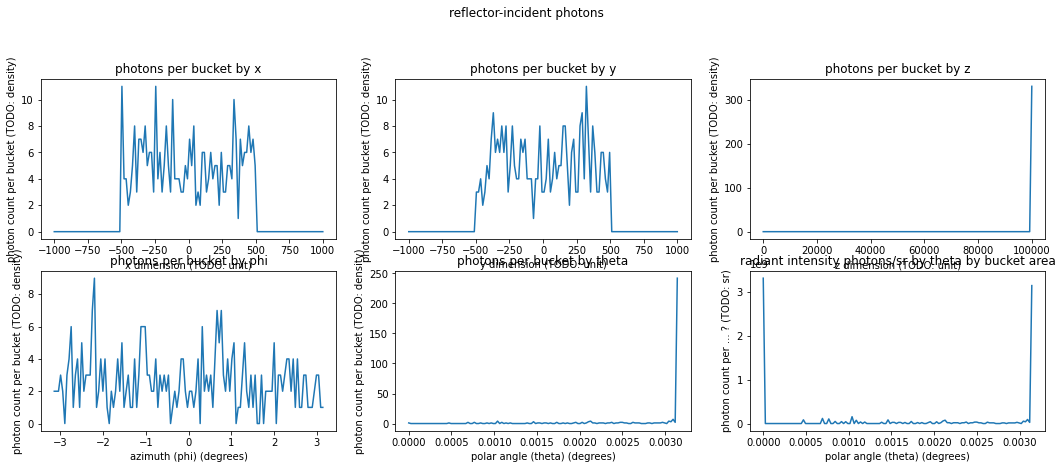

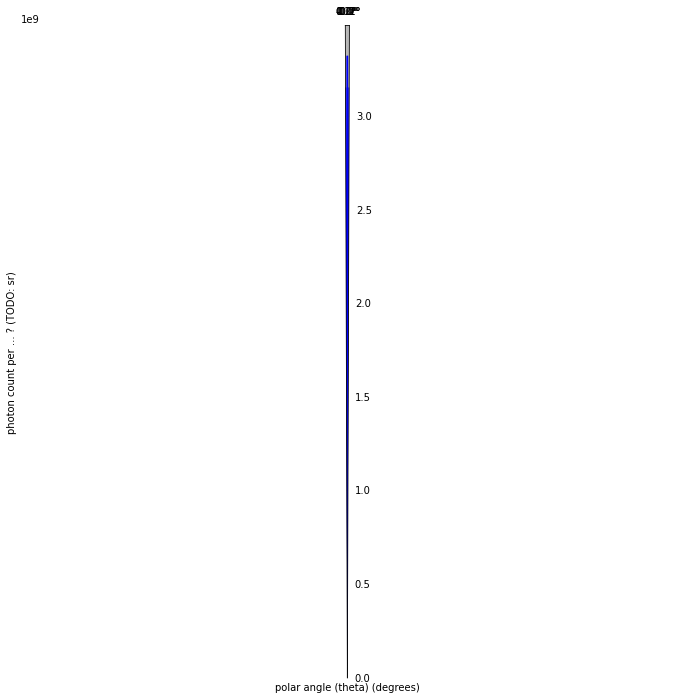

In [14]:
""" Show the distributions of reflector-incident photons """
plot_histogram_slices(photons, "reflector-incident photons",
                      x_min=-1000, x_max=1000,
                      y_min=-1000, y_max=1000,
                      z_min=0, z_max=reflector_distance,
                     theta_max = np.pi/1000)

In [15]:
reflector_sample = photons.sample()
print(reflector_sample)
(p,d) = reflector_sample
print(len(p))
print(p)
print(d[2])

(array([[ 1.52468063e+02,  1.63266220e+02,  1.00000000e+05],
       [-3.59800049e+02,  8.55357361e+01,  1.00000000e+05],
       [-1.23100281e+02,  3.63259583e+02,  1.00000000e+05],
       [ 2.44141403e+02,  3.70808990e+02,  1.00000000e+05],
       [ 1.30060730e+02, -3.55843018e+02,  1.00000000e+05],
       [ 3.31817108e+02,  3.31121826e+02,  1.00000000e+05],
       [ 3.46344543e+02, -3.12672668e+02,  1.00000000e+05],
       [-1.64104202e+02,  2.91247833e+02,  1.00000000e+05],
       [-4.20059448e+02, -4.42881561e+02,  1.00000000e+05],
       [-2.78997131e+02,  1.42837326e+02,  1.00000000e+05],
       [-4.89142334e+02, -2.79722565e+02,  1.00000000e+05],
       [ 4.64498444e+02,  1.74847168e+02,  1.00000000e+05],
       [ 4.84439789e+02, -1.35551514e+02,  1.00000000e+05],
       [-3.81702728e+02,  3.43057251e+02,  1.00000000e+05],
       [ 3.96827454e+02, -3.40951752e+02,  1.00000000e+05],
       [-1.66300629e+02,  2.30265091e+02,  1.00000000e+05],
       [ 3.05472946e+01,  2.21694138e+0

In [18]:
""" Show the generated, diffuser-transmitted, and reflector-incident photons in 3d. """
print(photons.size())
reflector_sample = photons.sample()
#print(reflector_sample)
#(p,d) = reflector_sample
#print(len(p))
#print(p)
#print(d[2])

reflector_box = [-500, 500, -500, 500, reflector_distance]
plot_3d([source_sample, box_sample, diff_sample, reflector_sample],
        ray_lengths=[10, 10, 100, 1000],
        boxes=[source_box, lightbox_box, diff_box, reflector_box],
        labels=['LED', 'lightbox', 'diffuser','reflector'],
        colors=[0xffff00, 0x00ffff, 0xff00ff, 0x808000])

332


Output()

In [ ]:
%%pyinstrument
""" Reflect the incident photons at the reflector. """
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
reflector = Diffuser(g = -0.9925, absorption=0.0)
reflector.diffuse(photons)
print(f"reflected photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
reflected_photons_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of reflected photons """
plot_histogram_slices(photons, "reflected photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=reflector_distance)

In [ ]:
""" Show the generated, transmitted, reflector-incident and reflected photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz, reflected_photons_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
""" Propagate the reflected photons to the camera plane. """
print(f"reflected photons: {Photon.countAlive(photons)}")
propagateToCamera(photons, location = lightbox_size) # make the camera height even with the diffuser
print(f"camera-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_camera_plane_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of camera-plane photons """
plot_histogram_slices(photons, "camera-plane photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=1000)

In [ ]:
""" Show the reflected photons in 3d."""
plot_rays([reflected_photons_viz, photons_at_camera_plane_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
""" Show the distributions of reflected photons, close up """
plot_histogram_slices(photons, "reflected photons", x_min=-2000, x_max=2000, y_min=-2000, y_max=2000, z_min=0, z_max=1000)

In [ ]:
""" Look closer at the neighborhood of the detector. """
plot_rays([photons_at_camera_plane_viz], 
          elev = 90, azim = 0, size = 5000, arrow_length = 1000,
          rectangles=[source_box, lightbox_box])